## <center> Predicting airbnb apartment prices using OLS, LASSO and Random Forest. <br/> Case study of Madrid city apartments. </center>

In [335]:
import pandas as pd
import numpy as np

from plotnine import *
from mizani.formatters import percent_format
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

from patsy import dmatrices
from sklearn.model_selection import train_test_split
from skranger.ensemble import RangerForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence
from sklearn.utils import resample
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [234]:
def plot_pred_true_scatter(true_price,predicted_price,title="asd"):
    fig, ax = plt.subplots(figsize=(5,5))
    plt.scatter(true_price, predicted_price)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.xlabel("True price")
    plt.ylabel("Predicted price")
    plt.title(title)
    plt.show()
    
def corr_pred(array):
    return np.exp(array)*np.exp(residual_std)

In [235]:
#Read the dataset

area='madrid'
data = pd.read_csv('airbnb_madrid_workfile.csv')
#Get all column names and general info about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11497 entries, 0 to 11496
Columns: 195 entries, price to id
dtypes: float64(8), int64(185), object(2)
memory usage: 17.1+ MB


In [329]:
data.isnull().sum().sum()

0

In [237]:
def count_missing_values(df):
    return df.isna().sum()[df.isna().sum() > 0]

In [238]:
count_missing_values(data)

Series([], dtype: int64)

In [239]:
data.price.describe(percentiles=[0.5,0.9,0.95,0.98])

count    11497.000000
mean       169.931835
std       1527.227521
min         10.000000
50%         98.000000
90%        212.000000
95%        300.000000
98%        500.000000
max      95150.000000
Name: price, dtype: float64

<AxesSubplot: >

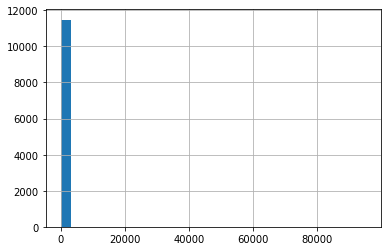

In [240]:
data.price.hist(bins=30)

<AxesSubplot: >

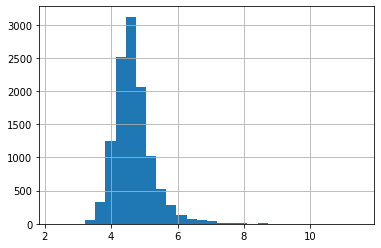

In [241]:
np.log(data.price).hist(bins=30)

In [242]:
#Create logprice variable as it is more meaningful
data["lnprice"] = np.log(data.price)

In [243]:
data.f_number_of_reviews.value_counts()

1    6359
2    3274
0    1864
Name: f_number_of_reviews, dtype: int64

In [349]:
data.f_property_type.value_counts()

Entire rental unit    10054
Entire condo            734
Entire loft             709
Name: f_property_type, dtype: int64

In [350]:
data.f_location.value_counts()

Centro                   6000
Salamanca                1009
Chamberí                  692
Arganzuela                592
Tetuán                    537
Retiro                    414
Chamartín                 360
Carabanchel               297
Moncloa - Aravaca         242
Ciudad Lineal             225
Puente de Vallecas        219
Latina                    173
Hortaleza                 169
Usera                     153
San Blas - Canillejas     139
Other                     114
Fuencarral - El Pardo     102
Villaverde                 60
Name: f_location, dtype: int64

In [244]:
data.columns = [
    item.replace("\\", "").replace(":", "") for item in data.columns.tolist()
]

In [298]:
data.drop(["id"],axis=1,inplace=True)

In [299]:
#Create train and holdout samples

data_train, data_holdout = train_test_split(data, train_size=0.7, random_state=42)

In [300]:
data_train.shape, data_holdout.shape

((8047, 194), (3450, 194))

In [301]:
data_train = data_train.loc[lambda x: x["price"] < x["price"].describe(percentiles=[0.98])["98%"]]

In [302]:
all_variables = [item.replace("\\","").replace(":","") for item in data.columns.tolist()[1:-19]]

target_variable = "price"

# interactions for the LASSO

X1 = [
    "n_accommodates:f_property_type",
    "f_property_type:n_dist_to_plaza_mayor",
    "n_accommodates:d_longtermstaysallowed",
    "d_breakfast:f_property_type",
    "d_kitchen:f_property_type",
    "d_elevator:f_property_type",
    "d_essentials:f_property_type"
]
# with locations
X2 = [
    "f_property_type:f_location",
    "n_accommodates:f_location",
]

predictors_tree = all_variables
predictors_lasso = all_variables + X1 + X2


In [303]:
len(predictors_lasso)

183

## OLS MODEL

In [304]:
y, X = dmatrices(target_variable + " ~ " + " + ".join(predictors_tree), data_train)
y_hold, X_test = dmatrices(
    target_variable + " ~ " + " + ".join(predictors_tree), data_holdout
)
y_hold_t, X_test_t = dmatrices(
    target_variable + " ~ " + " + ".join(predictors_tree),
    data_holdout.loc[lambda x: x["price"] < 190],
)

ols_model = LinearRegression().fit(X, y)

y_hat = ols_model.predict(X)

ols_rmse = mean_squared_error(y, y_hat, squared=False)
print(ols_rmse)

y_hat_test = ols_model.predict(X_test)
ols_rmse_test = mean_squared_error(y_hold, y_hat_test, squared=False)
print(ols_rmse_test)

y_hat_t = ols_model.predict(X_test_t)
ols_rmse_test_t = mean_squared_error(y_hold_t, y_hat_t, squared=False)
print(ols_rmse_test_t)

50.6304660409138
1797.291479324977
35.31351652361035


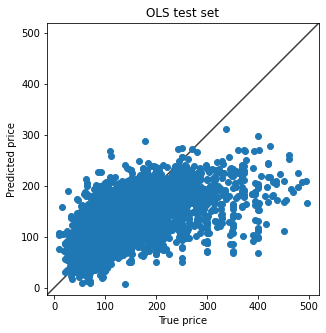

In [305]:
plot_pred_true_scatter(y, y_hat,title='OLS test set')

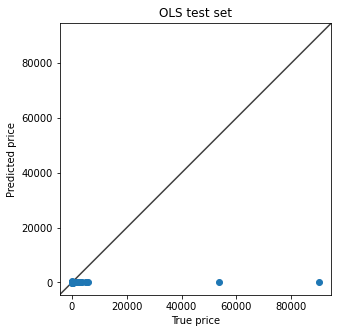

In [306]:
plot_pred_true_scatter(y_hold,y_hat_test,title='OLS test set')

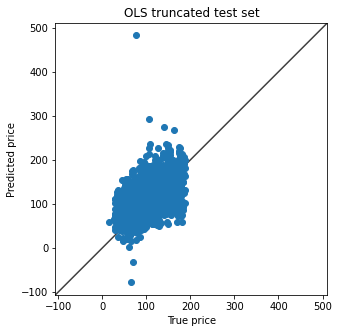

In [307]:
plot_pred_true_scatter(y_hold_t, y_hat_t,title='OLS truncated test set')

## LASSO MODEL

In [308]:
lasso_model = ElasticNet(l1_ratio=1, fit_intercept=True)

lasso_pipeline = Pipeline([("scale", StandardScaler()), ("regressor", lasso_model)])

lasso_model_cv = GridSearchCV(
    lasso_model,
    {"alpha": [i / 100 for i in range(10, 50, 3)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)



y, X = dmatrices(target_variable + " ~ " + " + ".join(predictors_lasso), data_train)

lasso_model_cv.fit(X, y.ravel())

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END .......................alpha=0.1;, score=-51.184 total time=   0.2s
[CV 2/5] END .......................alpha=0.1;, score=-51.732 total time=   0.2s
[CV 3/5] END .......................alpha=0.1;, score=-52.011 total time=   0.3s
[CV 4/5] END .......................alpha=0.1;, score=-48.876 total time=   0.3s
[CV 5/5] END .......................alpha=0.1;, score=-53.061 total time=   0.4s
[CV 1/5] END ......................alpha=0.13;, score=-51.175 total time=   0.2s
[CV 2/5] END ......................alpha=0.13;, score=-51.691 total time=   0.1s
[CV 3/5] END ......................alpha=0.13;, score=-52.076 total time=   0.2s
[CV 4/5] END ......................alpha=0.13;, score=-48.946 total time=   0.2s
[CV 5/5] END ......................alpha=0.13;, score=-53.154 total time=   0.3s
[CV 1/5] END ......................alpha=0.16;, score=-51.187 total time=   0.3s
[CV 2/5] END ......................alpha=0.16;, 

GridSearchCV(cv=5, estimator=ElasticNet(l1_ratio=1),
             param_grid={'alpha': [0.1, 0.13, 0.16, 0.19, 0.22, 0.25, 0.28,
                                   0.31, 0.34, 0.37, 0.4, 0.43, 0.46, 0.49]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [309]:
lasso_rmse = pd.DataFrame(lasso_model_cv.cv_results_).loc[
    lambda x: x.param_alpha == lasso_model_cv.best_estimator_.alpha
].mean_test_score.values[0] * -1
lasso_rmse

51.3728103086446

### Random Forest Model

In [311]:
rfr = RangerForestRegressor(importance="impurity",seed = 42)

tune_grid = {"mtry": [8, 10, 12], "min_node_size": [5, 10, 15]}

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

y, X = dmatrices(target_variable + " ~ " + " + ".join(predictors_tree), data_train)

rf_model = rf_random.fit(X,y.ravel())

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .........min_node_size=5, mtry=8;, score=-48.130 total time=   1.0s
[CV 2/5] END .........min_node_size=5, mtry=8;, score=-50.335 total time=   1.1s
[CV 3/5] END .........min_node_size=5, mtry=8;, score=-49.588 total time=   1.1s
[CV 4/5] END .........min_node_size=5, mtry=8;, score=-46.488 total time=   1.0s
[CV 5/5] END .........min_node_size=5, mtry=8;, score=-51.789 total time=   0.9s
[CV 1/5] END ........min_node_size=5, mtry=10;, score=-47.752 total time=   1.0s
[CV 2/5] END ........min_node_size=5, mtry=10;, score=-49.603 total time=   1.0s
[CV 3/5] END ........min_node_size=5, mtry=10;, score=-48.802 total time=   1.0s
[CV 4/5] END ........min_node_size=5, mtry=10;, score=-45.841 total time=   1.0s
[CV 5/5] END ........min_node_size=5, mtry=10;, score=-50.943 total time=   1.0s
[CV 1/5] END ........min_node_size=5, mtry=12;, score=-47.208 total time=   1.1s
[CV 2/5] END ........min_node_size=5, mtry=12;, s

In [312]:
pd.DataFrame(rf_model.cv_results_)[
    ["param_mtry", "param_min_node_size", "mean_test_score"]
].assign(
    mean_test_score=lambda x: x["mean_test_score"] * -1,
    Variables=lambda x: x["param_mtry"],
    Min_nodes=lambda x: x["param_min_node_size"] - 1,
).pivot(
    index="Min_nodes", columns="Variables", values="mean_test_score"
).round(
    2
)

Variables,8,10,12
Min_nodes,,,
4,49.27,48.59,48.24
9,49.58,49.02,48.67
14,49.88,49.46,49.08


### Choose better model

In [313]:
pd.DataFrame(
    {
        "RMSE": [
            ols_rmse,
            lasso_rmse,
            rf_model.cv_results_["mean_test_score"].max() *-1,
        ]
    },
    ["OLS", "Lasso CV", "Random Forest CV"],
).round(2)

,RMSE
OLS,50.63
Lasso CV,51.37
Random Forest CV,48.24


## Fit the final model

In [314]:
final_model = Pipeline([("scale", StandardScaler()), ("regressor", RandomForestRegressor(max_depth = 10))])

In [315]:
y, X = dmatrices(target_variable + " ~ " + " + ".join(predictors_tree), data_train)

rf_final_fit = final_model.fit(X,y.ravel())

y_hat = rf_final_fit.predict(X)

rf_rmse_train = mean_squared_error(y,y_hat,squared=False)
residual_std = np.std(y-y_hat)

print("Final model train rmse: "+str(rf_rmse_train))

y_hold, X_hold = dmatrices(target_variable + " ~ " + " + ".join(predictors_tree), data_holdout)

y_hat_test = rf_final_fit.predict(X_hold)

rf_rmse_test = mean_squared_error(y_hold,y_hat_test,squared=False)
print("Final model test rmse: "+ str(rf_rmse_test))

Final model train rmse: 35.867972605462136
Final model test rmse: 1797.2284120101033


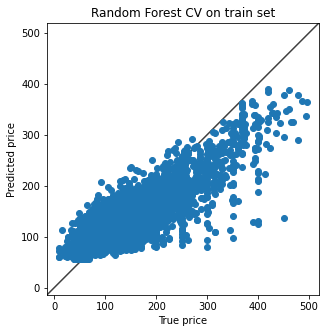

In [316]:
plot_pred_true_scatter(y,y_hat,title='Random Forest CV on train set')

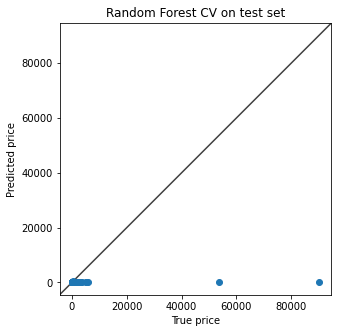

In [317]:
plot_pred_true_scatter(y_hold,y_hat_test,title='Random Forest CV on test set')

Final model truncated test rmse: 33.94629702438678


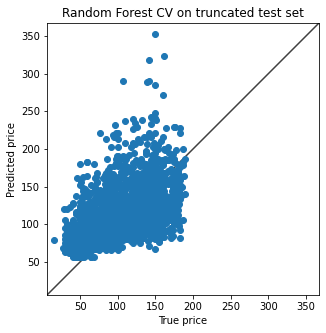

In [318]:
y_hold, X_hold = dmatrices(
    target_variable + " ~ " + " + ".join(predictors_tree),
    data_holdout.loc[lambda x: x["price"] < 190],
)

y_hat_test = rf_final_fit.predict(X_hold)

rf_rmse_test = mean_squared_error(y_hold, y_hat_test, squared=False)
print("Final model truncated test rmse: " + str(rf_rmse_test))
plot_pred_true_scatter(
    y_hold, y_hat_test, title="Random Forest CV on truncated test set"
)

## Model Diagnostics

In [319]:
final_model_var_imp_df = (
    pd.DataFrame(final_model.steps[1][1].feature_importances_, X.design_info.column_names)
    .reset_index()
    .rename({"index": "varname", 0: "imp"}, axis=1)
    .assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())
    .sort_values(by=["imp"], ascending=False)
)

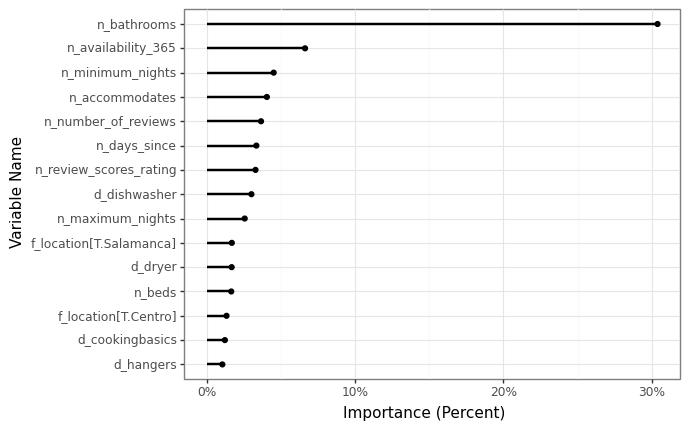

<ggplot: (135696020761)>

In [320]:
ggplot(
    final_model_var_imp_df.loc[lambda x: x["imp_percentage"]>0.01],
    aes(x="reorder(varname, imp)", y="imp_percentage"),
) + geom_point(size=1.5) + geom_segment(
    aes(x="varname", xend="varname", y=0, yend="imp_percentage"), size=1
) + ylab(
    "Importance (Percent)"
) + xlab(
    "Variable Name"
) + coord_flip() + scale_y_continuous(
    labels=percent_format()
) + theme_bw()

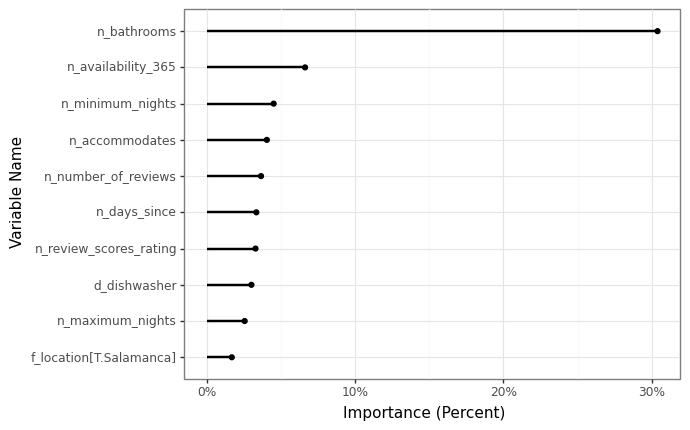

<ggplot: (135792634420)>

In [321]:
ggplot(
    final_model_var_imp_df.iloc[:10, :],
    aes(x="reorder(varname, imp)", y="imp_percentage"),
) + geom_point(size=1.5) + geom_segment(
    aes(x="varname", xend="varname", y=0, yend="imp_percentage"), size=1
) + ylab(
    "Importance (Percent)"
) + xlab(
    "Variable Name"
) + coord_flip() + scale_y_continuous(
    labels=percent_format()
) + theme_bw()

In [328]:
print("Shape of input data:", data_train.shape)

# check the feature names of the input data
print("Feature names in input data:", data_train.columns.tolist())

Shape of input data: (7882, 194)
Feature names in input data: ['price', 'f_location', 'n_bathrooms', 'n_accommodates', 'n_review_scores_rating', 'n_number_of_reviews', 'n_availability_365', 'n_minimum_nights', 'n_beds', 'n_maximum_nights', 'n_days_since', 'd_kitchen', 'd_longtermstaysallowed', 'd_wifi', 'd_essentials', 'd_hairdryer', 'd_hangers', 'd_iron', 'd_dishesandsilverware', 'd_heating', 'd_hotwater', 'd_refrigerator', 'd_washer', 'd_tv', 'd_microwave', 'd_cookingbasics', 'd_bedlinens', 'd_shampoo', 'd_airconditioning', 'd_coffeemaker', 'd_elevator', 'd_oven', 'd_dedicatedworkspace', 'd_dishwasher', 'd_stove', 'd_freezer', 'd_showergel', 'd_fireextinguisher', 'd_roomdarkeningshades', 'd_extrapillowsandblankets', 'd_cleaningproducts', 'd_dryingrackforclothing', 'd_diningtable', 'd_toaster', 'd_smokealarm', 'd_hostgreetsyou', 'd_bodysoap', 'd_hotwaterkettle', 'd_wineglasses', 'd_firstaidkit', 'd_freewasherinunit', 'd_selfcheckin', 'd_paidparkingoffpremises', 'd_carbonmonoxidealarm'

In [340]:
categorical_columns = [col for col in predictors_tree if col.startswith("f_")]
numerical_columns = [col for col in predictors_tree if col not in categorical_columns]

In [341]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

In [342]:

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

final_pipeline = Pipeline(
    [("preprocess", preprocessing), ("regressor", rf_final_fit)]
)


In [343]:
final_pipeline.fit(data_train[predictors_tree],data_train[target_variable])

ValueError: Selected columns, ['n_bathrooms', 'n_accommodates', 'n_review_scores_rating', 'n_number_of_reviews', 'n_availability_365', 'n_minimum_nights', 'n_beds', 'n_maximum_nights', 'n_days_since', 'd_kitchen', 'd_longtermstaysallowed', 'd_wifi', 'd_essentials', 'd_hairdryer', 'd_hangers', 'd_iron', 'd_dishesandsilverware', 'd_heating', 'd_hotwater', 'd_refrigerator', 'd_washer', 'd_tv', 'd_microwave', 'd_cookingbasics', 'd_bedlinens', 'd_shampoo', 'd_airconditioning', 'd_coffeemaker', 'd_elevator', 'd_oven', 'd_dedicatedworkspace', 'd_dishwasher', 'd_stove', 'd_freezer', 'd_showergel', 'd_fireextinguisher', 'd_roomdarkeningshades', 'd_extrapillowsandblankets', 'd_cleaningproducts', 'd_dryingrackforclothing', 'd_diningtable', 'd_toaster', 'd_smokealarm', 'd_hostgreetsyou', 'd_bodysoap', 'd_hotwaterkettle', 'd_wineglasses', 'd_firstaidkit', 'd_freewasherinunit', 'd_selfcheckin', 'd_paidparkingoffpremises', 'd_carbonmonoxidealarm', 'd_clothingstoragecloset', 'd_petsallowed', 'd_crib', 'd_privateentrance', 'd_dryer', 'd_luggagedropoffallowed', 'd_laundromatnearby', 'd_privatepatioorbalcony', 'd_coffee', 'd_patioorbalcony', 'd_ethernetconnection', 'd_acsplittypeductlesssystem', 'd_paidparkingonpremises', 'd_bathtub', 'd_smokingallowed', 'd_singlelevelhome', 'd_freestreetparking', 'd_clothingstorage', 'd_lockbox', 'd_cityskylineview', 'd_blender', 'd_packnplaytravelcrib', 'd_centralairconditioning', 'd_portablefans', 'd_centralheating', 'd_coffeemakernespresso', 'd_booksandreadingmaterial', 'd_highchair', 'd_smartlock', 'd_securitycamerasonproperty', 'd_freeparkingonpremises', 'd_tvwithstandardcable', 'd_minifridge', 'd_freedryerinunit', 'd_pocketwifi', 'd_paidparkinggarageoffpremises', 'd_breakfast', 'd_conditioner', 'd_bakingsheet', 'd_outdoorfurniture', 'd_electricstove', 'd_bidet', 'd_stainlesssteeloven', 'd_fastwifi', 'd_hdtv', 'd_outdoordiningarea', 'd_backyard', 'd_coffeemakerdripcoffeemaker', 'd_ceilingfan', 'd_babysitterrecommendations', 'd_netflix', 'd_heatingsplittypeductlesssystem', 'd_paidstreetparkingoffpremises', 'd_coffeemakerespressomachine', 'd_childrensbooksandtoys', 'd_childrensdinnerware', 'd_portableheater', 'd_buildingstaff', 'd_courtyardview', 'd_radiantheating', 'd_standardcable', 'd_windowguards', 'd_cribavailableuponrequest', 'd_babybath', 'd_inductionstove', 'd_hdtv', 'd_cleaningavailableduringstay', 'd_paidparkinglotoffpremises', 'd_hdtvwithstandardcable', 'd_pool', 'd_windowacunit', 'd_coffeemakerpourovercoffee', 'd_safe', 'd_hdtvwithamazonprimevideo', 'd_hdtvwithnetflix', 'd_outdoorshower', 'd_packnplaytravelcribavailableuponrequest', 'd_keypad', 'd_portableairconditioning', 'd_boardgames', 'd_sharedpatioorbalcony', 'd_hbomax', 'd_clothingstorageclosetanddresser', 'd_clothingstoragedresserandcloset', 'd_outletcovers', 'd_gym', 'd_indoorfireplace', 'd_privatebackyardfullyfenced', 'd_washerainunit', 'd_sharedpool', 'd_gardenview', 'd_hdtvwithstandardcable', 'd_paidpacknplaytravelcribavailableuponrequest', 'd_tv', 'd_paidcribavailableuponrequest', 'd_exerciseequipment', 'd_clothingstoragewardrobe', 'd_hottub', 'd_soundsystem', 'd_changingtable', 'd_amazonprimevideo', 'd_parkview', 'd_privatehottub', 'd_bathroomessentials', 'd_bedroomcomforts', 'd_freewasher', 'd_nespresso', 'd_babysafetygates', 'd_tvwithstandardcable', 'd_hdtvwithnetflix', 'd_bbqgrill', 'd_mosquitonet', 'd_clothingstoragedresser', 'd_clothingstoragewalkincloset', 'd_sharedbackyardfullyfenced', 'd_openspecifichours', 'd_fullkitchen', 'd_pourovercoffee', 'd_ricemaker', 'd_coffeemakerfrenchpress', 'd_hammock'], are not unique in dataframe

### I tried everything. Pipeline is somehow creating duplicate columns and my code is not running. 

In [344]:
# this takes a while to run
result = permutation_importance(
    final_pipeline,
    data_holdout[predictors_tree],
    data_holdout[target_variable],
    n_repeats=10,
    random_state=45,
)

AttributeError: 'ColumnTransformer' object has no attribute 'transformers_'

In [346]:
categorical_columns

['f_location']

In [347]:
grouped_imp = (
    pd.DataFrame(
        result.importances_mean,
        data_train[predictors_tree].columns,
    )
    .reset_index()
    .rename({"index": "varname", 0: "imp"}, axis=1)
    .assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())
    .sort_values(by=["imp"], ascending=False)
    .head(10)
)

NameError: name 'result' is not defined

In [348]:
varimp_p = ggplot(grouped_imp, aes(x="reorder(varname, imp)", y="imp_percentage")
) + geom_point(size=1.5, color = "#1f77b4"
) + geom_segment(
    aes(x="varname", xend="varname", y=0, yend="imp_percentage"), size=1, color = "#1f77b4"
) + ggtitle("Variable importance \n calculated from permutation importance on the holdout set"
) + ylab(
    "Importance (Percent)"
) + xlab(
    "Variable Name"
) + coord_flip() + scale_y_continuous(
    labels=percent_format()
) + theme_bw(
)
ggsave(varimp_p,filename='../figures/varimp.eps', dpi=1000)
varimp_p

NameError: name 'grouped_imp' is not defined

## Partial Dependence Plots

In [345]:
bath_pdp = partial_dependence(
    final_pipeline.fit(data_train[predictors_tree],data_train[target_variable]),
    data_holdout[predictors_tree].assign(
        n_bathrooms=lambda x: x["n_bathrooms"].astype(int)
    ),
    ["n_bathrooms"],
    kind="average",
)

bath_pdp = (
    pd.DataFrame(bath_pdp["average"], columns=bath_pdp["values"][0].tolist())
    .T.reset_index()
    .rename({0: "Predicted price", "index": "Bathrooms"}, axis=1)
)


n_bootstrap = 150

bathrooms = bath_pdp["Bathrooms"].tolist()
expected_value_bootstrap_replications = []
for _ in range(n_bootstrap):
    X_boot, y_boot = resample(
        data_holdout[predictors_tree].assign(
            n_bathrooms=lambda x: x["n_bathrooms"].astype(int)
        ),
        data_holdout[target_variable],
    )

    final_booted = final_pipeline.fit(X_boot, y_boot)

    expected_value_bootstrap_replications.append(
        partial_dependence(final_booted, X_boot, ["n_bathrooms"], kind="average")[
            "average"
        ][0]
    )

bath_pdp["prediction_se"] = (
    pd.DataFrame(expected_value_bootstrap_replications).dropna().std(axis=0).tolist()
)

ValueError: Selected columns, ['n_bathrooms', 'n_accommodates', 'n_review_scores_rating', 'n_number_of_reviews', 'n_availability_365', 'n_minimum_nights', 'n_beds', 'n_maximum_nights', 'n_days_since', 'd_kitchen', 'd_longtermstaysallowed', 'd_wifi', 'd_essentials', 'd_hairdryer', 'd_hangers', 'd_iron', 'd_dishesandsilverware', 'd_heating', 'd_hotwater', 'd_refrigerator', 'd_washer', 'd_tv', 'd_microwave', 'd_cookingbasics', 'd_bedlinens', 'd_shampoo', 'd_airconditioning', 'd_coffeemaker', 'd_elevator', 'd_oven', 'd_dedicatedworkspace', 'd_dishwasher', 'd_stove', 'd_freezer', 'd_showergel', 'd_fireextinguisher', 'd_roomdarkeningshades', 'd_extrapillowsandblankets', 'd_cleaningproducts', 'd_dryingrackforclothing', 'd_diningtable', 'd_toaster', 'd_smokealarm', 'd_hostgreetsyou', 'd_bodysoap', 'd_hotwaterkettle', 'd_wineglasses', 'd_firstaidkit', 'd_freewasherinunit', 'd_selfcheckin', 'd_paidparkingoffpremises', 'd_carbonmonoxidealarm', 'd_clothingstoragecloset', 'd_petsallowed', 'd_crib', 'd_privateentrance', 'd_dryer', 'd_luggagedropoffallowed', 'd_laundromatnearby', 'd_privatepatioorbalcony', 'd_coffee', 'd_patioorbalcony', 'd_ethernetconnection', 'd_acsplittypeductlesssystem', 'd_paidparkingonpremises', 'd_bathtub', 'd_smokingallowed', 'd_singlelevelhome', 'd_freestreetparking', 'd_clothingstorage', 'd_lockbox', 'd_cityskylineview', 'd_blender', 'd_packnplaytravelcrib', 'd_centralairconditioning', 'd_portablefans', 'd_centralheating', 'd_coffeemakernespresso', 'd_booksandreadingmaterial', 'd_highchair', 'd_smartlock', 'd_securitycamerasonproperty', 'd_freeparkingonpremises', 'd_tvwithstandardcable', 'd_minifridge', 'd_freedryerinunit', 'd_pocketwifi', 'd_paidparkinggarageoffpremises', 'd_breakfast', 'd_conditioner', 'd_bakingsheet', 'd_outdoorfurniture', 'd_electricstove', 'd_bidet', 'd_stainlesssteeloven', 'd_fastwifi', 'd_hdtv', 'd_outdoordiningarea', 'd_backyard', 'd_coffeemakerdripcoffeemaker', 'd_ceilingfan', 'd_babysitterrecommendations', 'd_netflix', 'd_heatingsplittypeductlesssystem', 'd_paidstreetparkingoffpremises', 'd_coffeemakerespressomachine', 'd_childrensbooksandtoys', 'd_childrensdinnerware', 'd_portableheater', 'd_buildingstaff', 'd_courtyardview', 'd_radiantheating', 'd_standardcable', 'd_windowguards', 'd_cribavailableuponrequest', 'd_babybath', 'd_inductionstove', 'd_hdtv', 'd_cleaningavailableduringstay', 'd_paidparkinglotoffpremises', 'd_hdtvwithstandardcable', 'd_pool', 'd_windowacunit', 'd_coffeemakerpourovercoffee', 'd_safe', 'd_hdtvwithamazonprimevideo', 'd_hdtvwithnetflix', 'd_outdoorshower', 'd_packnplaytravelcribavailableuponrequest', 'd_keypad', 'd_portableairconditioning', 'd_boardgames', 'd_sharedpatioorbalcony', 'd_hbomax', 'd_clothingstorageclosetanddresser', 'd_clothingstoragedresserandcloset', 'd_outletcovers', 'd_gym', 'd_indoorfireplace', 'd_privatebackyardfullyfenced', 'd_washerainunit', 'd_sharedpool', 'd_gardenview', 'd_hdtvwithstandardcable', 'd_paidpacknplaytravelcribavailableuponrequest', 'd_tv', 'd_paidcribavailableuponrequest', 'd_exerciseequipment', 'd_clothingstoragewardrobe', 'd_hottub', 'd_soundsystem', 'd_changingtable', 'd_amazonprimevideo', 'd_parkview', 'd_privatehottub', 'd_bathroomessentials', 'd_bedroomcomforts', 'd_freewasher', 'd_nespresso', 'd_babysafetygates', 'd_tvwithstandardcable', 'd_hdtvwithnetflix', 'd_bbqgrill', 'd_mosquitonet', 'd_clothingstoragedresser', 'd_clothingstoragewalkincloset', 'd_sharedbackyardfullyfenced', 'd_openspecifichours', 'd_fullkitchen', 'd_pourovercoffee', 'd_ricemaker', 'd_coffeemakerfrenchpress', 'd_hammock'], are not unique in dataframe

In [351]:
accom_pdp = partial_dependence(
    final_pipeline, data_holdout[predictors_tree], ["n_accommodates"], kind="average"
)

accom_pdp = (
    pd.DataFrame(accom_pdp["average"], columns=accom_pdp["values"][0].tolist())
    .T.reset_index()
    .rename({0: "Predicted price", "index": "Accomodates (person)"}, axis=1)
)


n_bootstrap = 50

accomodates = accom_pdp["Accomodates (person)"].tolist()
expected_value_bootstrap_replications = []
for _ in range(n_bootstrap):
    X_boot, y_boot = resample(
        data_holdout[predictors_tree], data_holdout[target_variable]
    )

    final_booted = final_pipeline.fit(X_boot, y_boot)

    expected_value_bootstrap_replications.append(
        partial_dependence(final_booted, X_boot, ["n_accommodates"], kind="average")[
            "average"
        ][0]
    )


accom_pdp["prediction_se"] = np.std(expected_value_bootstrap_replications, axis=0)[0]

NotFittedError: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

NameError: name 'bathrooms' is not defined

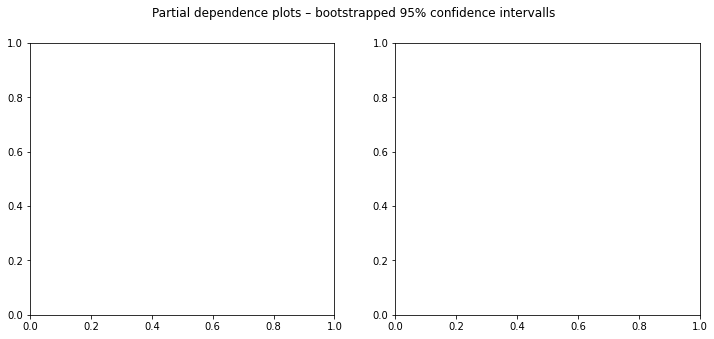

In [352]:
fig, (ax1, ax2) = plt.subplots(1, 2,sharey=False,figsize=(12,5))
fig.suptitle('Partial dependence plots – bootstrapped 95% confidence intervalls')


ax1.plot(bathrooms, bath_pdp["Predicted price"], marker="o")
ax1.fill_between(
    bathrooms,
    bath_pdp["Predicted price"] - 1.96 * bath_pdp["prediction_se"],
    bath_pdp["Predicted price"] + 1.96 * bath_pdp["prediction_se"],
    alpha=0.5,
    label="Bootstrap 95%CI",
)
ax1.set_xlabel("Bathrooms")
ax1.grid()
ax1.set_yticks([i*10 for i in range(2,9)])
ax1.set_xticks(bathrooms)


ax2.plot(accomodates, accom_pdp["Predicted price"], marker="o")
ax2.fill_between(
    accomodates,
    accom_pdp["Predicted price"] - 1.96 * accom_pdp["prediction_se"],
    accom_pdp["Predicted price"] + 1.96 * accom_pdp["prediction_se"],
    alpha=0.5,
    label="Bootstrap 95%CI",
)
ax2.set_ylabel("Predicted price (EUR)")
ax2.set_xlabel("Accomodates")
ax2.grid()
ax2.set_xticks(accomodates)
ax2.set_yticks([i*10 for i in range(2,9)])




plt.savefig("../figures/PDP_plot.png")
plt.show()